In [1]:
#para apagar diretório de modelos quando for gerar novos modelos
#import shutil
#diretorio_a_apagar = './backup'
#shutil.rmtree(diretorio_a_apagar)

In [2]:
#para executar esse projeto é necessário ter a seguintes libs instaladas
#pip install pandas
#pip install scipy
#pip install autogluon
#pip install opendatasets --upgrade
#pip install -U imbalanced-learn
#pip install neurokit2

In [3]:
#libs "básicas"
import os
import csv
import numpy as np
import pandas as pd
import neurokit2 as nk
from scipy import stats
import matplotlib.pyplot as plt

#libs que auxiliam os modelos
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#lib para importar base de dados
import opendatasets as od

A base de dados é oficialmente compartilhada pela [PhysioNet](https://www.physionet.org/content/mitdb/1.0.0/), porém, executando a linha a seguir, a mesma base de dados é obtida através da plataforma kaggle com auxílio da biblioteca opendatasets.

In [4]:
od.download("https://www.kaggle.com/datasets/taejoongyoon/mitbit-arrhythmia-database?datasetId=52320&sortBy=voteCount")

Skipping, found downloaded files in "./mitbit-arrhythmia-database" (use force=True to force download)


## Pré processamento
Iremos analisar os modelos com dados sem remoção de ruído e com remoção de ruído

#### Variáveis auxiliares

In [5]:
path = './mitbit-arrhythmia-database/mitbih_database/'
window_size = 1000
maximum_counting = 10000

classes = ['N','L','R','A','V']
n_classes = len(classes)
count_classes = {elemento: 0 for elemento in classes}

X = list()
y = list()

In [6]:
description_beats = {'N':'Batida normal', 'L':'Batida de bloqueio de ramo esquerdo',
                     'R':'Batida de bloqueio de ramo direito','A':'Batimento atrial prematuro',
                     'a':'Batimento atrial prematuro aberrado','J':'Batimento prematuro nodal (juncional)',
                     'S':'Batimento supraventricular prematuro ou ectópico (atrial ou nodal)',
                     'V':'Contração ventricular prematura','F':'Fusão de batimento ventricular e normal',
                     'e':'Batida de escape atrial','j':'Batida de escape nodal (juncional)',
                     'E':'Batida de escape ventricular','/':'Batida ritmada',
                     'f':'Fusão de batida ritmada e normal','Q': 'Batida inclassificável'}

#### Preparo dos arquivos

In [7]:
# Leitura dos arquivos
filenames = next(os.walk(path))[2]

# Para separar e salvar os arquivos em csv e txt
records = list()
annotations = list()
filenames.sort()

In [8]:
# Definindo nomes de arquivos e anotações
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

In [9]:
len(records), len(annotations)

(48, 48)

#### Extração dos dados e pré processamento sem remoção de rúido

In [10]:
%%time
# Registros
X_with_noise = list() #x contém os valores do sinais
y_with_noise = list() #y para os rótulos
z_with_noise = list() #z indica o índice do registro

for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # ler arquivo csv
        next(spamreader) # ignora header
        for row in spamreader:
            signals.append(int(row[1]))
                
    # Normalizando os dados: https://www.investopedia.com/terms/z/zscore.asp
    signals = stats.zscore(signals)
    
    
    with open(annotations[r], 'r') as fileID:
        lines = fileID.readlines()[1:] # 0 índice é o cabeçalho do gráfico, ignora o header

        for line in lines:
            row = list(filter(lambda item: item != '', line.split(' ')))
            time, sample, arrhythmia_type = row[0:3]
            pos = int(sample)

            if(arrhythmia_type in classes): # Verificar se é uma classe válida
                # Contar a quantidade de dados de cada classe
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_type] += 1
                
                # pos é o momento que foi feita a analise.
                if(window_size <= pos and (pos + window_size) < len(signals)):
                    # pega uma janela de tempo onde o pos fica no meio
                    beat = signals[pos-window_size:pos+window_size]
        
                    X_with_noise.append(beat)
                    y_with_noise.append(arrhythmia_index)
                    z_with_noise.append(os.path.splitext(os.path.basename(records[r]))[0])

print(np.shape(X_with_noise), np.shape(y_with_noise))

(99754, 2000) (99754,)
CPU times: user 19.6 s, sys: 771 ms, total: 20.4 s
Wall time: 20.4 s


Utilizamos a coluna ``record_id`` afim de facilitar consultas relacionadas a qual registro pertence cada linha em casos de dúvidas, mas a coluna não é utilizada nos modelos.

In [11]:
noisy_database = pd.DataFrame(data=X_with_noise)
noisy_database['label'] = y_with_noise
noisy_database['record_id'] = z_with_noise
noisy_database.head()

,0,1,2,3,4,5,6,7,8,9,...,1992,1993,1994,1995,1996,1997,1998,1999,label,record_id
0,0.136123,0.136123,0.110243,0.162003,0.162003,0.213763,0.187883,0.110243,0.084363,0.136123,...,-0.252076,-0.329716,-0.226196,-0.226196,-0.226196,-0.200316,-0.226196,-0.252076,0,100
1,-0.045036,-0.019156,0.058483,0.084363,0.006723,-0.019156,-0.070916,-0.045036,0.032603,-0.045036,...,-1.002596,-0.924956,-0.950836,-0.924956,-1.002596,-1.002596,-0.950836,-0.899076,0,100
2,-0.226196,-0.174436,-0.148556,-0.122676,-0.148556,-0.174436,-0.277956,-0.226196,-0.226196,-0.252076,...,-0.614396,-0.588516,-0.536756,-0.536756,-0.588516,-0.640276,-0.614396,-0.588516,0,100
3,-0.407356,-0.329716,-0.303836,-0.329716,-0.355596,-0.226196,-0.148556,-0.070916,-0.045036,-0.070916,...,-0.381476,-0.355596,-0.381476,-0.407356,-0.484996,-0.407356,-0.381476,-0.355596,3,100
4,-0.174436,-0.122676,-0.070916,-0.045036,-0.096796,-0.148556,-0.252076,-0.200316,-0.174436,-0.148556,...,0.032603,0.136123,0.162003,0.239643,0.239643,0.187883,0.213763,0.265523,0,100


In [12]:
noisy_database.shape

(99754, 2002)

In [13]:
noisy_database['label'].value_counts()

0    74815
1     8053
2     7235
4     7114
3     2537
Name: label, dtype: int64

#### Extração dos dados e pré processamento com remoção de rúido

O parâmetro de taxa de amostragem (sampling rate) ideal pode depender da frequência de amostragem original dos seus dados. O ideal é que a taxa de amostragem seja preservada durante todo o processamento para evitar perda de informações importantes.

In [14]:
def denoise(ecg): 
    #sampling_rate ( int ) – A frequência de amostragem do sinal (em Hz, ou seja, amostras/segundo).
    data = nk.ecg_clean(ecg, sampling_rate=360, method="neurokit")     
    return data

In [15]:
%%time
# Registros
X = list() #x contém os valores do sinais
y = list() #y para os rótulos
Z = list() #z indica o índice do registro

for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # ler arquivo csv
        next(spamreader) # ignora header
        for row in spamreader:
            signals.append(int(row[1]))
            
    signals = denoise(signals)
    
    # Normalizando os dados: https://www.investopedia.com/terms/z/zscore.asp
    signals = stats.zscore(signals)
    
    
    with open(annotations[r], 'r') as fileID:
        lines = fileID.readlines()[1:] # 0 índice é o cabeçalho do gráfico, ignora o header

        for line in lines:
            row = list(filter(lambda item: item != '', line.split(' ')))
            time, sample, arrhythmia_type = row[0:3]
            pos = int(sample)

            if(arrhythmia_type in classes): # Verificar se é uma classe válida
                # Contar a quantidade de dados de cada classe
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_type] += 1
                
                # pos é o momento que foi feita a analise.
                if(window_size <= pos and (pos + window_size) < len(signals)):
                    # pega uma janela de tempo onde o pos fica no meio
                    beat = signals[pos-window_size:pos+window_size]
        
                    X.append(beat)
                    y.append(arrhythmia_index)
                    Z.append(os.path.splitext(os.path.basename(records[r]))[0])

print(np.shape(X), np.shape(y))

(99754, 2000) (99754,)
CPU times: user 19.4 s, sys: 669 ms, total: 20.1 s
Wall time: 20 s


In [16]:
database = pd.DataFrame(data=X)
database['label'] = y
database['record_id'] = Z
database.head()

,0,1,2,3,4,5,6,7,8,9,...,1992,1993,1994,1995,1996,1997,1998,1999,label,record_id
0,0.083958,0.085536,0.086416,0.088665,0.088838,0.087622,0.083642,0.076895,0.068760,0.059927,...,-0.054384,-0.054374,-0.052298,-0.049536,-0.048844,-0.048154,-0.048845,-0.051606,0,100
1,0.178741,0.185196,0.190959,0.191895,0.187314,0.179973,0.170562,0.162526,0.153797,0.141620,...,-0.946181,-0.940877,-0.933509,-0.919941,-0.904997,-0.885232,-0.856511,-0.822968,0,100
2,-0.000832,-0.011242,-0.021651,-0.032751,-0.046607,-0.061154,-0.077079,-0.090937,-0.104795,-0.115897,...,-0.581727,-0.585270,-0.587435,-0.590290,-0.593146,-0.592557,-0.583699,-0.567260,0,100
3,-0.290699,-0.266626,-0.235661,-0.198491,-0.155118,-0.104853,-0.053208,-0.001562,0.043882,0.084502,...,-0.558391,-0.553579,-0.551522,-0.552220,-0.554294,-0.553609,-0.552233,-0.551544,3,100
4,0.016099,0.016617,0.015064,0.010063,0.002304,-0.006148,-0.015980,-0.019611,-0.018420,-0.012407,...,0.087004,0.123378,0.156308,0.187862,0.214592,0.238568,0.260477,0.279630,0,100


**Comparação dos tipos de batidas com e sem ruído**

### Análise dos dados
Nessa análise não importa se a base de dados é ``noisy_database`` ou ``database`` porque estamos analisando a quantidade de classes e não a qualidade do sinal.

In [17]:
database.dtypes.value_counts()

float64    2000
int64         1
object        1
dtype: int64

In [18]:
database['label'].value_counts()

0    74815
1     8053
2     7235
4     7114
3     2537
Name: label, dtype: int64

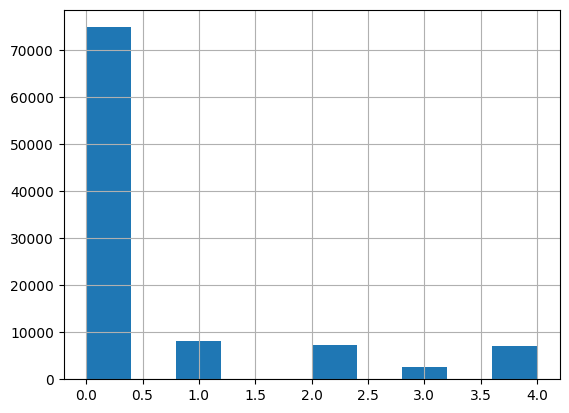

In [19]:
database['label'].hist();

## AutoML com sinais ruidosos

In [20]:
#removendo a coluna record_id pois ela não é necessária nas classificações 
noisy_database2 = noisy_database.iloc[:, :-1]
train_data, test_data = train_test_split(noisy_database2, random_state=42, stratify=noisy_database2.label)
train_data.shape, test_data.shape 

((74815, 2001), (24939, 2001))

In [21]:
X_train, y_train = train_data.iloc[:,:-1], train_data['label']
X_test, y_test = test_data.iloc[:,:-1], test_data['label']
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((74815, 2000), (24939, 2000), (74815,), (24939,))

In [22]:
%%time
predictor = TabularPredictor(label='label').fit(train_data, time_limit=28800, hyperparameter_tune_kwargs = 
                                                {'num_trials': 5, 'scheduler' : 'local', 'searcher': 'auto'})

Fitted model: NeuralNetTorch/523a3c13 ...
	0.99	 = Validation score   (accuracy)
	293.03s	 = Training   runtime
	2.79s	 = Validation runtime
Fitted model: NeuralNetTorch/331cf39a ...
	0.9694	 = Validation score   (accuracy)
	171.58s	 = Training   runtime
	0.3s	 = Validation runtime
Fitted model: NeuralNetTorch/0804615d ...
	0.9924	 = Validation score   (accuracy)
	1957.01s	 = Training   runtime
	2.79s	 = Validation runtime
Fitted model: NeuralNetTorch/962d0db5 ...
	0.9934	 = Validation score   (accuracy)
	994.22s	 = Training   runtime
	2.76s	 = Validation runtime
Fitted model: NeuralNetTorch/ec2a69c8 ...
	0.9764	 = Validation score   (accuracy)
	267.81s	 = Training   runtime
	2.92s	 = Validation runtime
Fitting model: LightGBMLarge ... Training model for up to 1992.59s of the 18180.73s of remaining time.
	0.9882	 = Validation score   (accuracy)
	907.63s	 = Training   runtime
	0.3s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 2878.18s of the 1724

CPU times: user 14h 28min 35s, sys: 35min 26s, total: 15h 4min 2s
Wall time: 3h 12min 43s


### Dataframe de hiperparâmetros

Iremos usar 3 métodos para os modelos do AutoGluon, o primeiro sem reamostragem, o segundo utilizando a técnica de reamostragem SMOTE e o terceiro a técnica de reamostragem ADASYN. Por isso, para auxiliar o acesso dos hiperparâmetros utilizaremos um dataframe.

A função ``autogluon_models_df`` trata as informações dos modelos gerados pelo TabularPredictor e retorna um dataframe com um ranking de acurácia dos modelos e facilita o processo de seleção/visualização dos hiperparâmetros de cada modelo. O datafame contém as seguintes informações: a segmentação usada, se o filtro foi aplicado, a técnica de reamostragem, o nome do modelo, os hiperparâmetros do modelo e acurácia. Nesse notebook executamos os modelos com a segmentação dos dados com uma janela de 180.

In [23]:
def autogluon_models_df(window, filter_applied, resampling_tech, predictor_model, test_data_):
    leaderboard = predictor_model.leaderboard(test_data_, silent=True, extra_metrics=['accuracy','precision_weighted','recall_weighted', 'f1_weighted'])
    all_models = predictor_model.get_model_names()
    predictor_information = predictor_model.info()
    autogluon_accuracy = []
    autogluon_precision = []
    autogluon_f1 = []
    autogluon_recall = []
    autogluon_hyperparameters = []
    autogluon_algorithms = [] 
    for model in all_models:
        if model != 'WeightedEnsemble_L2':
            autogluon_algorithms.append(model)
            accuracy = (leaderboard.accuracy[leaderboard['model'] == model]).values[0]
            precision_weighted = (leaderboard.precision_weighted[leaderboard['model'] == model]).values[0]
            recall_weighted = (leaderboard.recall_weighted[leaderboard['model'] == model]).values[0]
            f1_weighted = (leaderboard.f1_weighted[leaderboard['model'] == model]).values[0]
            
            autogluon_accuracy.append(accuracy)
            autogluon_precision.append(precision_weighted)
            autogluon_recall.append(recall_weighted)
            autogluon_f1.append(f1_weighted)
            
            autogluon_hyperparameters.append(predictor_information["model_info"][model]["hyperparameters"])
            
    window_size_list = [window*2]*len(autogluon_algorithms)
    filter_applied_list = [filter_applied]*len(autogluon_algorithms)
    resampling_tech_list = [resampling_tech]*len(autogluon_algorithms)
        
    
    autogluon_args = list(zip(window_size_list, filter_applied_list, resampling_tech_list, 
                              autogluon_algorithms, autogluon_hyperparameters, autogluon_accuracy,
                             autogluon_precision, autogluon_recall, autogluon_f1))    
    
    hyperparameters = pd.DataFrame(autogluon_args, columns=['window_size','filter_applied','resampling_tech',
                                                            'model','hyperparameters','accuracy',
                                                            'precision_weighted','recall_weighted', 'f1_weighted'])
    
    hyperparameters = hyperparameters.sort_values(by='accuracy', ascending=False)
    hyperparameters = hyperparameters.reset_index(drop=True)
    
    #agrupamento por algoritmos
    hyperparameters['algorithm'] = ''
    all_algorithms = ['LightGBM', 'RandomForest', 'NeuralNetTorch', 'NeuralNetFastAI', 'XGBoost',
                      'ExtraTrees', 'CatBoost', 'KNeighbors']
    
    hyperparameters.loc[hyperparameters['model'].str.contains('LightGBM'), 'algorithm'] = 'LightGBM'
    hyperparameters.loc[hyperparameters['model'].str.contains('RandomForest'), 'algorithm'] = 'RandomForest'
    hyperparameters.loc[hyperparameters['model'].str.contains('NeuralNetTorch'), 'algorithm'] = 'NeuralNetTorch'
    hyperparameters.loc[hyperparameters['model'].str.contains('NeuralNetFastAI'), 'algorithm'] = 'NeuralNetFastAI'
    hyperparameters.loc[hyperparameters['model'].str.contains('XGBoost'), 'algorithm'] = 'XGBoost'
    hyperparameters.loc[hyperparameters['model'].str.contains('ExtraTrees'), 'algorithm'] = 'ExtraTrees'
    hyperparameters.loc[hyperparameters['model'].str.contains('CatBoost'), 'algorithm'] = 'CatBoost'
    hyperparameters.loc[hyperparameters['model'].str.contains('KNeighbors'), 'algorithm'] = 'KNeighbors'
    
    return hyperparameters

In [24]:
%%time
model_without_resampling = autogluon_models_df(window=window_size,
                                               filter_applied=False, 
                                               resampling_tech=None,
                                               predictor_model=predictor,
                                               test_data_=test_data)

CPU times: user 16min 23s, sys: 3.09 s, total: 16min 26s
Wall time: 2min 24s


**Ranking dos modelos sem reamostragem e sem filtro**

In [25]:
model_without_resampling.head(2)

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm
0,2000,False,None,NeuralNetFastAI/76554e76,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.992261,0.992192,0.992261,0.992205,NeuralNetFastAI
1,2000,False,None,NeuralNetTorch/962d0db5,"{'num_epochs': 500, 'epochs_wo_improve': 20, 'activation': 'elu', 'embedding_size_factor': 0.6, 'embed_exponent': 0.56, 'max_embedding_dim': 100, 'y_range': None, 'y_range_extend': 0.05, 'dropout_prob': 0.2, 'optimizer': 'adam', 'learning_rate': 0.01301814743912817, 'weight_decay': 1.3209894849025664e-12, 'proc.embed_min_categories': 3, 'proc.impute_strategy': 'median', 'proc.max_category_levels': 1000, 'proc.skew_threshold': 0.9, 'use_ngram_features': False, 'num_layers': 3, 'hidden_size': 256, 'max_batch_size': 512, 'use_batchnorm': True, 'loss_function': 'auto'}",0.992061,0.992008,0.992061,0.991949,NeuralNetTorch


**Cálculo do intervalo de confiança**

In [139]:
z = 1.96
accuracy = 0.9922
n = len(X_test)
interval = z * np.sqrt((accuracy * (1 - accuracy)) / n)
print(f"Intervalo de confiança{(accuracy-interval, accuracy+interval)}")

Intervalo de confiança(0.991108148773116, 0.9932918512268839)


In [26]:
model_without_resampling['algorithm'].value_counts()

LightGBM           7
NeuralNetFastAI    5
NeuralNetTorch     5
RandomForest       2
ExtraTrees         2
KNeighbors         2
XGBoost            1
CatBoost           1
Name: algorithm, dtype: int64

In [27]:
model_without_resampling['algorithm'].value_counts().sum()

25

Para evitar perda dos dados

In [28]:
model_without_resampling.to_csv('model_without_resampling.csv', index=False)

### AutoML com técnica de reamostragem SMOTE

In [29]:
# Aplicar SMOTE apenas no conjunto de treinamento
smote = SMOTE(sampling_strategy='auto')

In [30]:
print("Distribuição de classes sem a reamostragem: ", Counter(y_train))

Distribuição de classes sem a reamostragem:  Counter({0: 56111, 1: 6040, 2: 5426, 4: 5335, 3: 1903})


In [31]:
%%time
X_resampled_smote, y_resampled_smote = smote.fit_resample(X_train, y_train)

CPU times: user 33.9 s, sys: 2.92 s, total: 36.8 s
Wall time: 16 s


In [32]:
print("Distribuição de classes após a reamostragem: ", Counter(y_resampled_smote))

Distribuição de classes após a reamostragem:  Counter({4: 56111, 0: 56111, 2: 56111, 1: 56111, 3: 56111})


In [33]:
resampled_smote = X_resampled_smote.join(y_resampled_smote)
resampled_smote.head()

,0,1,2,3,4,5,6,7,8,9,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,label
0,0.129698,0.179569,0.179569,0.196193,0.162946,0.146322,0.113075,0.162946,0.196193,0.212816,...,-0.285891,-0.302514,-0.219396,-0.202773,-0.236020,-0.269267,-0.302514,-0.269267,-0.236020,4
1,0.096508,0.110943,0.168684,0.211990,0.183119,0.139814,0.067638,0.053202,0.038767,0.038767,...,0.558435,0.587306,0.688352,0.760529,0.774964,0.746093,0.832705,0.948187,0.933751,0
2,1.121642,1.148811,1.203150,1.257489,1.352582,1.488429,1.529183,1.569938,1.597107,1.637861,...,-0.685127,-0.657958,-0.671542,-0.671542,-0.671542,-0.617204,-0.590034,-0.576449,-0.549280,0
3,-0.004539,-0.047844,-0.062279,-0.134456,-0.148891,-0.206632,-0.148891,-0.120020,-0.091150,-0.120020,...,-0.134456,0.024332,0.139814,0.298601,0.428518,0.572871,0.688352,0.760529,0.717223,0
4,0.698712,0.743159,0.743159,0.713528,0.639449,0.580185,0.565370,0.609817,0.624633,0.624633,...,-0.323578,-0.293947,-0.353210,-0.338394,-0.338394,-0.368026,-0.382842,-0.397657,-0.368026,0


In [34]:
%%time
smote_resampling_training = TabularPredictor(label='label').fit(resampled_smote, time_limit=28800, 
                                                                hyperparameter_tune_kwargs = {'num_trials': 5, 'scheduler' : 'local', 'searcher': 'auto'})

Fitted model: NeuralNetTorch/853b33bc ...
	0.9991	 = Validation score   (accuracy)
	885.04s	 = Training   runtime
	3.23s	 = Validation runtime
Fitted model: NeuralNetTorch/c115cb1f ...
	0.9993	 = Validation score   (accuracy)
	1966.03s	 = Training   runtime
	0.33s	 = Validation runtime
Fitted model: NeuralNetTorch/92127fad ...
	0.9993	 = Validation score   (accuracy)
	857.62s	 = Training   runtime
	0.34s	 = Validation runtime
Fitted model: NeuralNetTorch/eaaf05bb ...
	0.9982	 = Validation score   (accuracy)
	232.72s	 = Training   runtime
	0.35s	 = Validation runtime
Fitting model: LightGBMLarge ... Training model for up to 1989.76s of the 14974.09s of remaining time.
	To avoid this warning, specify the model hyperparameter "ag.max_memory_usage_ratio" to a larger value (currently 1.0, set to >=0.80 to avoid the warning)
		To set the same value for all models, do the following when calling predictor.fit: `predictor.fit(..., ag_args_fit={"ag.max_memory_usage_ratio": VALUE})`
	0.9984	 = Va

CPU times: user 20h 45min 16s, sys: 19min 31s, total: 21h 4min 47s
Wall time: 4h 16min 26s


**Dataframe de hiperparâmetros**

A função ``autogluon_models_df`` trata as informações dos modelos gerados pelo TabularPredictor e retorna um dataframe com um ranking de acurácia dos modelos e facilita o processo de seleção/visualização dos hiperparâmetros de cada modelo. O datafame contém as seguintes informações: a segmentação usada, se o filtro foi aplicado, a técnica de reamostragem, o nome do modelo, os hiperparâmetros do modelo e acurácia. Nesse notebook executamos os modelos com a segmentação dos dados com uma janela de 180.

In [35]:
%%time
models_with_smote = autogluon_models_df(window=window_size,
                                        filter_applied=False, 
                                        resampling_tech='smote',
                                        predictor_model=smote_resampling_training,
                                        test_data_=test_data)

CPU times: user 1min 18s, sys: 4.71 s, total: 1min 23s
Wall time: 32.3 s


**Ranking dos modelos com a técnica de reamostragem SMOTE e sem filtro**

In [36]:
models_with_smote.head(2)

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm
0,2000,False,smote,LightGBMXT/T1,"{'learning_rate': 0.05, 'extra_trees': True, 'feature_fraction': 1.0, 'min_data_in_leaf': 20, 'num_leaves': 31}",0.99194,0.991851,0.99194,0.991854,LightGBM
1,2000,False,smote,NeuralNetFastAI/54e545e1,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.99166,0.991561,0.99166,0.991557,NeuralNetFastAI


**Cálculo do intervalo de confiança**

In [150]:
z = 1.96
accuracy = 0.9918
n = len(X_test)
interval = z * np.sqrt((accuracy * (1 - accuracy)) / n)
print(f"Intervalo de confiança{(accuracy-interval, accuracy+interval)}")

Intervalo de confiança(0.9906807282771989, 0.9929192717228011)


In [37]:
models_with_smote['algorithm'].value_counts()

NeuralNetTorch     4
LightGBM           3
NeuralNetFastAI    2
RandomForest       2
ExtraTrees         2
XGBoost            1
CatBoost           1
Name: algorithm, dtype: int64

In [38]:
models_with_smote['algorithm'].value_counts().sum()

15

Para evitar perda dos dados

In [39]:
models_with_smote.to_csv('models_with_smote.csv', index=False)

**Junção dos modelos**

In [40]:
hyperparameters_all_models = pd.concat([models_with_smote, model_without_resampling])

In [41]:
hyperparameters_all_models = hyperparameters_all_models.sort_values(by='accuracy', ascending=False)

In [42]:
hyperparameters_all_models = hyperparameters_all_models.reset_index(drop=True)

In [43]:
hyperparameters_all_models.head(2)

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm
0,2000,False,None,NeuralNetFastAI/76554e76,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.992261,0.992192,0.992261,0.992205,NeuralNetFastAI
1,2000,False,None,NeuralNetTorch/962d0db5,"{'num_epochs': 500, 'epochs_wo_improve': 20, 'activation': 'elu', 'embedding_size_factor': 0.6, 'embed_exponent': 0.56, 'max_embedding_dim': 100, 'y_range': None, 'y_range_extend': 0.05, 'dropout_prob': 0.2, 'optimizer': 'adam', 'learning_rate': 0.01301814743912817, 'weight_decay': 1.3209894849025664e-12, 'proc.embed_min_categories': 3, 'proc.impute_strategy': 'median', 'proc.max_category_levels': 1000, 'proc.skew_threshold': 0.9, 'use_ngram_features': False, 'num_layers': 3, 'hidden_size': 256, 'max_batch_size': 512, 'use_batchnorm': True, 'loss_function': 'auto'}",0.992061,0.992008,0.992061,0.991949,NeuralNetTorch


### AutoML com técnica de reamostragem ADASYN

In [44]:
print("Distribuição de classes sem a reamostragem: ", Counter(y_train))

Distribuição de classes sem a reamostragem:  Counter({0: 56111, 1: 6040, 2: 5426, 4: 5335, 3: 1903})


In [45]:
adasyn = ADASYN(sampling_strategy='minority', random_state=42)
X_resampled_adasyn, y_resampled_adasyn = adasyn.fit_resample(X_train, y_train)

In [46]:
print("Distribuição de classes após a reamostragem: ", Counter(y_resampled_adasyn))

Distribuição de classes após a reamostragem:  Counter({3: 56127, 0: 56111, 1: 6040, 2: 5426, 4: 5335})


In [47]:
resampled_adasyn = X_resampled_adasyn.join(y_resampled_adasyn)

In [48]:
%%time
adasyn_resampling_training = TabularPredictor(label='label').fit(resampled_adasyn, time_limit=28800,
                                                                 hyperparameter_tune_kwargs = {'num_trials': 5, 'scheduler' : 'local', 'searcher': 'auto'})

Fitted model: NeuralNetTorch/a5777c2d ...
	0.9968	 = Validation score   (accuracy)
	538.51s	 = Training   runtime
	3.25s	 = Validation runtime
Fitted model: NeuralNetTorch/7e8041c1 ...
	0.997	 = Validation score   (accuracy)
	1649.68s	 = Training   runtime
	0.35s	 = Validation runtime
Fitted model: NeuralNetTorch/cdacc347 ...
	0.9984	 = Validation score   (accuracy)
	1133.24s	 = Training   runtime
	2.79s	 = Validation runtime
Fitted model: NeuralNetTorch/174cf165 ...
	0.9978	 = Validation score   (accuracy)
	770.34s	 = Training   runtime
	2.82s	 = Validation runtime
Fitted model: NeuralNetTorch/bdf7bada ...
	0.8776	 = Validation score   (accuracy)
	299.45s	 = Training   runtime
	3.9s	 = Validation runtime
Fitting model: LightGBMLarge ... Training model for up to 1991.73s of the 18397.94s of remaining time.
	Ran out of time, early stopping on iteration 876. Best iteration is:
	[864]	valid_set's multi_error: 0.0036
	0.9964	 = Validation score   (accuracy)
	1999.07s	 = Training   runtime


CPU times: user 15h 52min 11s, sys: 27min 7s, total: 16h 19min 18s
Wall time: 3h 27min 4s


**Dataframe de hiperparâmetros**

A função ``autogluon_models_df`` trata as informações dos modelos gerados pelo TabularPredictor e retorna um dataframe com um ranking de acurácia dos modelos e facilita o processo de seleção/visualização dos hiperparâmetros de cada modelo. O datafame contém as seguintes informações: a segmentação usada, se o filtro foi aplicado, a técnica de reamostragem, o nome do modelo, os hiperparâmetros do modelo e acurácia. Nesse notebook executamos os modelos com a segmentação dos dados com uma janela de 180.

In [49]:
%%time
models_with_adasyn = autogluon_models_df(window=window_size,
                                        filter_applied=False, 
                                        resampling_tech='adasyn',
                                        predictor_model=adasyn_resampling_training,
                                        test_data_=test_data)

CPU times: user 2min 29s, sys: 6.35 s, total: 2min 35s
Wall time: 1min 11s


**Ranking dos modelos com a técnica de reamostragem ADASYN e sem filtro**

In [50]:
models_with_adasyn.head(2)

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm
0,2000,False,adasyn,NeuralNetFastAI/c859f25a,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.9919,0.991847,0.9919,0.991864,NeuralNetFastAI
1,2000,False,adasyn,NeuralNetTorch/cdacc347,"{'num_epochs': 500, 'epochs_wo_improve': 20, 'activation': 'elu', 'embedding_size_factor': 0.7, 'embed_exponent': 0.56, 'max_embedding_dim': 100, 'y_range': None, 'y_range_extend': 0.05, 'dropout_prob': 0.4, 'optimizer': 'adam', 'learning_rate': 0.000540093288600174, 'weight_decay': 5.0084921880402506e-11, 'proc.embed_min_categories': 100, 'proc.impute_strategy': 'median', 'proc.max_category_levels': 200, 'proc.skew_threshold': 1.0, 'use_ngram_features': False, 'num_layers': 3, 'hidden_size': 512, 'max_batch_size': 512, 'use_batchnorm': True, 'loss_function': 'auto'}",0.9919,0.991817,0.9919,0.991818,NeuralNetTorch


**Cálculo do intervalo de confiança**

In [151]:
z = 1.96
accuracy = 0.9918
n = len(X_test)
interval = z * np.sqrt((accuracy * (1 - accuracy)) / n)
print(f"Intervalo de confiança{(accuracy-interval, accuracy+interval)}")

Intervalo de confiança(0.9906807282771989, 0.9929192717228011)


In [51]:
models_with_adasyn['algorithm'].value_counts()

NeuralNetFastAI    5
NeuralNetTorch     5
LightGBM           3
RandomForest       2
ExtraTrees         2
XGBoost            1
CatBoost           1
Name: algorithm, dtype: int64

In [52]:
models_with_adasyn['algorithm'].value_counts().sum()

19

Para evitar perda dos dados

In [53]:
models_with_adasyn.to_csv('models_with_adasyn.csv', index=False)

**Junção dos modelos**

In [54]:
hyperparameters_all_models = pd.concat([hyperparameters_all_models, models_with_adasyn])

In [55]:
hyperparameters_all_models = hyperparameters_all_models.sort_values(by='accuracy', ascending=False)

In [56]:
hyperparameters_all_models = hyperparameters_all_models.reset_index(drop=True)

In [57]:
hyperparameters_all_models.head()

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm
0,2000,False,None,NeuralNetFastAI/76554e76,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.992261,0.992192,0.992261,0.992205,NeuralNetFastAI
1,2000,False,None,NeuralNetTorch/962d0db5,"{'num_epochs': 500, 'epochs_wo_improve': 20, 'activation': 'elu', 'embedding_size_factor': 0.6, 'embed_exponent': 0.56, 'max_embedding_dim': 100, 'y_range': None, 'y_range_extend': 0.05, 'dropout_prob': 0.2, 'optimizer': 'adam', 'learning_rate': 0.01301814743912817, 'weight_decay': 1.3209894849025664e-12, 'proc.embed_min_categories': 3, 'proc.impute_strategy': 'median', 'proc.max_category_levels': 1000, 'proc.skew_threshold': 0.9, 'use_ngram_features': False, 'num_layers': 3, 'hidden_size': 256, 'max_batch_size': 512, 'use_batchnorm': True, 'loss_function': 'auto'}",0.992061,0.992008,0.992061,0.991949,NeuralNetTorch
2,2000,False,smote,LightGBMXT/T1,"{'learning_rate': 0.05, 'extra_trees': True, 'feature_fraction': 1.0, 'min_data_in_leaf': 20, 'num_leaves': 31}",0.991940,0.991851,0.991940,0.991854,LightGBM
3,2000,False,adasyn,NeuralNetTorch/cdacc347,"{'num_epochs': 500, 'epochs_wo_improve': 20, 'activation': 'elu', 'embedding_size_factor': 0.7, 'embed_exponent': 0.56, 'max_embedding_dim': 100, 'y_range': None, 'y_range_extend': 0.05, 'dropout_prob': 0.4, 'optimizer': 'adam', 'learning_rate': 0.000540093288600174, 'weight_decay': 5.0084921880402506e-11, 'proc.embed_min_categories': 100, 'proc.impute_strategy': 'median', 'proc.max_category_levels': 200, 'proc.skew_threshold': 1.0, 'use_ngram_features': False, 'num_layers': 3, 'hidden_size': 512, 'max_batch_size': 512, 'use_batchnorm': True, 'loss_function': 'auto'}",0.991900,0.991817,0.991900,0.991818,NeuralNetTorch
4,2000,False,adasyn,NeuralNetFastAI/c859f25a,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.991900,0.991847,0.991900,0.991864,NeuralNetFastAI


## AutoML com redução de ruído

In [58]:
#removendo a coluna record_id pois ela não é necessária nas classificações 
database2 = database.iloc[:, :-1]
train_data2, test_data2 = train_test_split(database2, random_state=42, stratify=database2.label)
train_data2.shape, test_data2.shape 

((74815, 2001), (24939, 2001))

In [59]:
X_train2, y_train2 = train_data2.iloc[:,:-1], train_data2['label']
X_test2, y_test2 = test_data2.iloc[:,:-1], test_data2['label']
X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape

((74815, 2000), (24939, 2000), (74815,), (24939,))

In [60]:
%%time
predictor2 = TabularPredictor(label='label').fit(train_data2, time_limit=28800, hyperparameter_tune_kwargs = 
                                                {'num_trials': 5, 'scheduler' : 'local', 'searcher': 'auto'})

Fitted model: NeuralNetTorch/0cd113f2 ...
	0.9914	 = Validation score   (accuracy)
	427.11s	 = Training   runtime
	3.01s	 = Validation runtime
Fitted model: NeuralNetTorch/862903f6 ...
	0.9918	 = Validation score   (accuracy)
	1260.75s	 = Training   runtime
	2.84s	 = Validation runtime
Fitted model: NeuralNetTorch/948df250 ...
	0.9944	 = Validation score   (accuracy)
	456.02s	 = Training   runtime
	2.83s	 = Validation runtime
Fitted model: NeuralNetTorch/7e766644 ...
	0.993	 = Validation score   (accuracy)
	454.91s	 = Training   runtime
	2.89s	 = Validation runtime
Fitted model: NeuralNetTorch/75b88add ...
	0.9928	 = Validation score   (accuracy)
	346.66s	 = Training   runtime
	3.99s	 = Validation runtime
Fitting model: LightGBMLarge ... Training model for up to 1992.33s of the 19578.87s of remaining time.
	0.992	 = Validation score   (accuracy)
	736.59s	 = Training   runtime
	0.33s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 2877.81s of the 18

CPU times: user 14h 22min 12s, sys: 15min 19s, total: 14h 37min 31s
Wall time: 2h 46min 38s


In [158]:
y_pred_LightGBM = predictor2.predict(data=X_test2, model='LightGBM/T5')

In [159]:
print(classification_report(y_test2, y_pred_LightGBM, digits=4))

              precision    recall  f1-score   support

           0     0.9938    0.9991    0.9965     18704
           1     0.9985    0.9950    0.9968      2013
           2     0.9983    0.9939    0.9961      1809
           3     0.9844    0.8975    0.9389       634
           4     0.9937    0.9775    0.9855      1779

    accuracy                         0.9943     24939
   macro avg     0.9938    0.9726    0.9828     24939
weighted avg     0.9943    0.9943    0.9942     24939



**Dataframe de hiperparâmetros**

A função ``autogluon_models_df`` trata as informações dos modelos gerados pelo TabularPredictor e retorna um dataframe com um ranking de acurácia dos modelos e facilita o processo de seleção/visualização dos hiperparâmetros de cada modelo. O datafame contém as seguintes informações: a segmentação usada, se o filtro foi aplicado, a técnica de reamostragem, o nome do modelo, os hiperparâmetros do modelo e acurácia. Nesse notebook executamos os modelos com a segmentação dos dados com uma janela de 180.

In [61]:
%%time
model_without_resampling2 = autogluon_models_df(window=window_size,
                                        filter_applied=True, 
                                        resampling_tech=None,
                                        predictor_model=predictor2,
                                        test_data_=test_data2)

/home/jupyter-luana@alu.ufc.br/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-luana@alu.ufc.br/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CPU times: user 16min 31s, sys: 9.94 s, total: 16min 41s
Wall time: 2min 44s


**Ranking dos modelos com sem técnica de reamostragem e com filtro**

In [62]:
model_without_resampling2.head(2)

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm
0,2000,True,None,LightGBM/T5,"{'learning_rate': 0.1000260297171191, 'feature_fraction': 0.8694162793303375, 'min_data_in_leaf': 48, 'num_leaves': 53}",0.994306,0.994288,0.994306,0.994235,LightGBM
1,2000,True,None,LightGBMXT/T1,"{'learning_rate': 0.05, 'extra_trees': True, 'feature_fraction': 1.0, 'min_data_in_leaf': 20, 'num_leaves': 31}",0.994306,0.994299,0.994306,0.994237,LightGBM


**Cálculo do intervalo de confiança**

In [152]:
z = 1.96
accuracy = 0.9942
n = len(X_test2)
interval = z * np.sqrt((accuracy * (1 - accuracy)) / n)
print(f"Intervalo de confiança{(accuracy-interval, accuracy+interval)}")

Intervalo de confiança(0.993257530227932, 0.995142469772068)


In [63]:
model_without_resampling2['algorithm'].value_counts()

LightGBM           11
NeuralNetFastAI     5
NeuralNetTorch      5
CatBoost            3
XGBoost             2
RandomForest        2
ExtraTrees          2
KNeighbors          2
Name: algorithm, dtype: int64

In [64]:
model_without_resampling2['algorithm'].value_counts().sum()

32

Para evitar perda dos dados

In [65]:
model_without_resampling2.to_csv('model_without_resampling2.csv', index=False)

**Junção dos modelos**

In [66]:
hyperparameters_all_models = pd.concat([hyperparameters_all_models, model_without_resampling2])

In [67]:
hyperparameters_all_models = hyperparameters_all_models.sort_values(by='accuracy', ascending=False)

In [68]:
hyperparameters_all_models = hyperparameters_all_models.reset_index(drop=True)

In [69]:
hyperparameters_all_models.head()

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm
0,2000,True,None,LightGBM/T5,"{'learning_rate': 0.1000260297171191, 'feature_fraction': 0.8694162793303375, 'min_data_in_leaf': 48, 'num_leaves': 53}",0.994306,0.994288,0.994306,0.994235,LightGBM
1,2000,True,None,LightGBMXT/T1,"{'learning_rate': 0.05, 'extra_trees': True, 'feature_fraction': 1.0, 'min_data_in_leaf': 20, 'num_leaves': 31}",0.994306,0.994299,0.994306,0.994237,LightGBM
2,2000,True,None,LightGBMXT/T2,"{'learning_rate': 0.06994332504138302, 'extra_trees': True, 'feature_fraction': 0.8872033759818312, 'min_data_in_leaf': 5, 'num_leaves': 83}",0.994266,0.994259,0.994266,0.994198,LightGBM
3,2000,True,None,LightGBM/T1,"{'learning_rate': 0.05, 'feature_fraction': 1.0, 'min_data_in_leaf': 20, 'num_leaves': 31}",0.994146,0.994128,0.994146,0.994078,LightGBM
4,2000,True,None,LightGBMXT/T3,"{'learning_rate': 0.049883446878335284, 'extra_trees': True, 'feature_fraction': 0.9618129346960314, 'min_data_in_leaf': 52, 'num_leaves': 52}",0.993985,0.993970,0.993985,0.993917,LightGBM


### AutoML com técnica de reamostragem SMOTE

In [70]:
# Aplicar SMOTE apenas no conjunto de treinamento
smote2 = SMOTE(sampling_strategy='auto')

In [71]:
print("Distribuição de classes sem a reamostragem: ", Counter(y_train2))

Distribuição de classes sem a reamostragem:  Counter({0: 56111, 1: 6040, 2: 5426, 4: 5335, 3: 1903})


In [72]:
%%time
X_resampled_smote2, y_resampled_smote2 = smote2.fit_resample(X_train2, y_train2)

CPU times: user 33.8 s, sys: 4.42 s, total: 38.2 s
Wall time: 17.2 s


In [73]:
print("Distribuição de classes após a reamostragem: ", Counter(y_resampled_smote2))

Distribuição de classes após a reamostragem:  Counter({4: 56111, 0: 56111, 2: 56111, 1: 56111, 3: 56111})


In [74]:
resampled_smote2 = X_resampled_smote2.join(y_resampled_smote2)
resampled_smote2.head()

,0,1,2,3,4,5,6,7,8,9,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,label
0,-0.434222,-0.434585,-0.435710,-0.436447,-0.437179,-0.436757,-0.435564,-0.434366,-0.432397,-0.431190,...,-0.319199,-0.324999,-0.327344,-0.328915,-0.331245,-0.332036,-0.330520,-0.326314,-0.320185,4
1,-0.158962,-0.158999,-0.160543,-0.165858,-0.173435,-0.182519,-0.190847,-0.195025,-0.192036,-0.178860,...,0.723021,0.781442,0.847032,0.913755,0.974445,1.028348,1.075463,1.113528,1.138015,0
2,1.197179,1.288934,1.377502,1.462881,1.544115,1.619606,1.687758,1.748572,1.802047,1.845948,...,-0.449014,-0.427503,-0.406965,-0.385806,-0.365302,-0.344176,-0.323386,-0.302613,-0.282176,0
3,-0.295335,-0.339569,-0.381166,-0.418616,-0.449656,-0.475796,-0.495525,-0.514880,-0.536501,-0.563405,...,-0.496680,-0.393084,-0.269501,-0.138379,-0.018577,0.075193,0.133125,0.151824,0.131667,0
4,0.527236,0.548620,0.556048,0.551574,0.538071,0.518823,0.495883,0.470482,0.440158,0.402448,...,-0.664026,-0.650069,-0.639383,-0.630737,-0.624953,-0.622029,-0.618272,-0.611630,-0.599638,0


In [75]:
%%time
smote_resampling_training2 = TabularPredictor(label='label').fit(resampled_smote2, time_limit=28800,
                                                                 hyperparameter_tune_kwargs = {'num_trials': 5, 'scheduler' : 'local', 'searcher': 'auto'})

Fitted model: NeuralNetTorch/8af21cab ...
	0.9996	 = Validation score   (accuracy)
	1117.84s	 = Training   runtime
	2.95s	 = Validation runtime
Fitted model: NeuralNetTorch/019800f0 ...
	0.9995	 = Validation score   (accuracy)
	1979.56s	 = Training   runtime
	0.36s	 = Validation runtime
Fitting model: LightGBMLarge ... Training model for up to 1989.38s of the 19413.1s of remaining time.
	To avoid this warning, specify the model hyperparameter "ag.max_memory_usage_ratio" to a larger value (currently 1.0, set to >=1.12 to avoid the warning)
		To set the same value for all models, do the following when calling predictor.fit: `predictor.fit(..., ag_args_fit={"ag.max_memory_usage_ratio": VALUE})`
		Setting "ag.max_memory_usage_ratio" to values above 1 may result in out-of-memory errors. You may consider using a machine with more memory as a safer alternative.
	0.9993	 = Validation score   (accuracy)
	1367.05s	 = Training   runtime
	0.22s	 = Validation runtime
Fitting model: WeightedEnsemble

CPU times: user 15h 2min 5s, sys: 18min 14s, total: 15h 20min 19s
Wall time: 2h 59min 28s


**Dataframe de hiperparâmetros**

A função ``autogluon_models_df`` trata as informações dos modelos gerados pelo TabularPredictor e retorna um dataframe com um ranking de acurácia dos modelos e facilita o processo de seleção/visualização dos hiperparâmetros de cada modelo. O datafame contém as seguintes informações: a segmentação usada, se o filtro foi aplicado, a técnica de reamostragem, o nome do modelo, os hiperparâmetros do modelo e acurácia. Nesse notebook executamos os modelos com a segmentação dos dados com uma janela de 180.

In [76]:
%%time
models_with_smote2 = autogluon_models_df(window=window_size,
                                        filter_applied=True, 
                                        resampling_tech='smote',
                                        predictor_model=smote_resampling_training2,
                                        test_data_=test_data2)

CPU times: user 45.3 s, sys: 2.69 s, total: 48 s
Wall time: 21.5 s


**Ranking dos modelos com a técnica de reamostragem SMOTE e com filtro**

In [77]:
models_with_smote2.head(2)

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm
0,2000,True,smote,RandomForestGini,"{'n_estimators': 300, 'max_leaf_nodes': 15000, 'n_jobs': -1, 'random_state': 0, 'bootstrap': True, 'criterion': 'gini'}",0.993665,0.993631,0.993665,0.993639,RandomForest
1,2000,True,smote,XGBoost/T1,"{'n_estimators': 10000, 'learning_rate': 0.1, 'n_jobs': -1, 'proc.max_category_levels': 100, 'objective': 'multi:softmax', 'booster': 'gbtree', 'num_class': 5, 'max_depth': 6, 'min_child_weight': 1, 'colsample_bytree': 1.0}",0.993264,0.993274,0.993264,0.993268,XGBoost


**Cálculo do intervalo de confiança**

In [147]:
z = 1.96
accuracy = 0.9936
n = len(X_test2)
interval = z * np.sqrt((accuracy * (1 - accuracy)) / n)
print(f"Intervalo de confiança{(accuracy-interval, accuracy+interval)}")

Intervalo de confiança(0.9926102800326063, 0.9945897199673938)


In [78]:
models_with_smote2['algorithm'].value_counts()

RandomForest      2
ExtraTrees        2
NeuralNetTorch    2
XGBoost           1
LightGBM          1
CatBoost          1
Name: algorithm, dtype: int64

In [79]:
models_with_smote2['algorithm'].value_counts().sum()

9

Para evitar perda dos dados

In [80]:
models_with_smote2.to_csv('models_with_smote2.csv', index=False)

**Junção dos modelos**

In [81]:
hyperparameters_all_models = pd.concat([hyperparameters_all_models, models_with_smote2])

In [82]:
hyperparameters_all_models = hyperparameters_all_models.sort_values(by='accuracy', ascending=False)

In [83]:
hyperparameters_all_models = hyperparameters_all_models.reset_index(drop=True)

In [84]:
hyperparameters_all_models.head()

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm
0,2000,True,None,LightGBM/T5,"{'learning_rate': 0.1000260297171191, 'feature_fraction': 0.8694162793303375, 'min_data_in_leaf': 48, 'num_leaves': 53}",0.994306,0.994288,0.994306,0.994235,LightGBM
1,2000,True,None,LightGBMXT/T1,"{'learning_rate': 0.05, 'extra_trees': True, 'feature_fraction': 1.0, 'min_data_in_leaf': 20, 'num_leaves': 31}",0.994306,0.994299,0.994306,0.994237,LightGBM
2,2000,True,None,LightGBMXT/T2,"{'learning_rate': 0.06994332504138302, 'extra_trees': True, 'feature_fraction': 0.8872033759818312, 'min_data_in_leaf': 5, 'num_leaves': 83}",0.994266,0.994259,0.994266,0.994198,LightGBM
3,2000,True,None,LightGBM/T1,"{'learning_rate': 0.05, 'feature_fraction': 1.0, 'min_data_in_leaf': 20, 'num_leaves': 31}",0.994146,0.994128,0.994146,0.994078,LightGBM
4,2000,True,None,LightGBMXT/T3,"{'learning_rate': 0.049883446878335284, 'extra_trees': True, 'feature_fraction': 0.9618129346960314, 'min_data_in_leaf': 52, 'num_leaves': 52}",0.993985,0.993970,0.993985,0.993917,LightGBM


### AutoML com técnica de reamostragem ADASYN

In [85]:
print("Distribuição de classes sem a reamostragem: ", Counter(y_train2))

Distribuição de classes sem a reamostragem:  Counter({0: 56111, 1: 6040, 2: 5426, 4: 5335, 3: 1903})


In [86]:
adasyn2 = ADASYN(sampling_strategy='minority', random_state=42)
X_resampled_adasyn2, y_resampled_adasyn2 = adasyn.fit_resample(X_train2, y_train2)

In [87]:
print("Distribuição de classes após a reamostragem: ", Counter(y_resampled_adasyn2))

Distribuição de classes após a reamostragem:  Counter({3: 56215, 0: 56111, 1: 6040, 2: 5426, 4: 5335})


In [88]:
resampled_adasyn2 = X_resampled_adasyn2.join(y_resampled_adasyn2)

In [89]:
%%time
adasyn_resampling_training2 = TabularPredictor(label='label').fit(resampled_adasyn2, time_limit=28800,
                                                                  hyperparameter_tune_kwargs = {'num_trials': 5, 'scheduler' : 'local', 'searcher': 'auto'})

2023-11-29 15:40:13,106	ERROR trial_runner.py:1062 -- Trial 25287f76: Error processing event.
ray.tune.error._TuneNoNextExecutorEventError: Traceback (most recent call last):
  File "/home/jupyter-luana@alu.ufc.br/.local/lib/python3.9/site-packages/ray/tune/execution/ray_trial_executor.py", line 1276, in get_next_executor_event
    future_result = ray.get(ready_future)
  File "/home/jupyter-luana@alu.ufc.br/.local/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/home/jupyter-luana@alu.ufc.br/.local/lib/python3.9/site-packages/ray/_private/worker.py", line 2382, in get
    raise value
ray.exceptions.OutOfMemoryError: Task was killed due to the node running low on memory.
Memory on the node (IP: 10.102.21.240, ID: 074bbfb73096c29403d0deb5346edcca93f5fb8c54df75850b3d9c75) where the task (actor ID: e83a9c95278cb2ba9ec4e6a701000000, name=ImplicitFunc.__init__, pid=486787, memory used=6.12GB) was running was 90.55GB

CPU times: user 15h 33min 5s, sys: 22min 41s, total: 15h 55min 47s
Wall time: 2h 56min 51s


**Dataframe de hiperparâmetros**

A função ``autogluon_models_df`` trata as informações dos modelos gerados pelo TabularPredictor e retorna um dataframe com um ranking de acurácia dos modelos e facilita o processo de seleção/visualização dos hiperparâmetros de cada modelo. O datafame contém as seguintes informações: a segmentação usada, se o filtro foi aplicado, a técnica de reamostragem, o nome do modelo, os hiperparâmetros do modelo e acurácia. Nesse notebook executamos os modelos com a segmentação dos dados com uma janela de 180.

In [90]:
%%time
models_with_adasyn2 = autogluon_models_df(window=window_size,
                                        filter_applied=True, 
                                        resampling_tech='adasyn',
                                        predictor_model=adasyn_resampling_training2,
                                        test_data_=test_data2)

CPU times: user 2min, sys: 6.2 s, total: 2min 6s
Wall time: 1min 1s


In [153]:
adasyn_resampling_training2.get_model_names()

['NeuralNetFastAI/c0aee8c0',
 'NeuralNetFastAI/3107cb28',
 'NeuralNetFastAI/95df2851',
 'NeuralNetFastAI/aa31cf95',
 'NeuralNetFastAI/10bd4af3',
 'LightGBMXT/T1',
 'LightGBMXT/T2',
 'LightGBMXT/T3',
 'LightGBM/T1',
 'LightGBM/T2',
 'LightGBM/T3',
 'RandomForestGini',
 'RandomForestEntr',
 'CatBoost/T1',
 'ExtraTreesGini',
 'ExtraTreesEntr',
 'XGBoost/T1',
 'XGBoost/T2',
 'NeuralNetTorch/1a5f21f9',
 'NeuralNetTorch/e06d0ade',
 'NeuralNetTorch/13b50236',
 'LightGBMLarge',
 'WeightedEnsemble_L2']

In [156]:
y_pred_lua = adasyn_resampling_training2.predict(data=X_test2, model='LightGBMXT/T1')

In [157]:
print(classification_report(y_test, y_pred_lua, digits=4))

              precision    recall  f1-score   support

           0     0.9951    0.9977    0.9964     18704
           1     0.9980    0.9950    0.9965      2013
           2     0.9989    0.9950    0.9970      1809
           3     0.9270    0.9416    0.9343       634
           4     0.9960    0.9702    0.9829      1779

    accuracy                         0.9939     24939
   macro avg     0.9830    0.9799    0.9814     24939
weighted avg     0.9939    0.9939    0.9939     24939



**Ranking dos modelos com a técnica de reamostragem SMOTE e com filtro**

In [91]:
models_with_adasyn2.head(2)

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm
0,2000,True,adasyn,LightGBMXT/T1,"{'learning_rate': 0.05, 'extra_trees': True, 'feature_fraction': 1.0, 'min_data_in_leaf': 20, 'num_leaves': 31}",0.993905,0.993936,0.993905,0.993905,LightGBM
1,2000,True,adasyn,LightGBMXT/T3,"{'learning_rate': 0.049883446878335284, 'extra_trees': True, 'feature_fraction': 0.9618129346960314, 'min_data_in_leaf': 52, 'num_leaves': 52}",0.993264,0.993297,0.993264,0.993266,LightGBM


**Cálculo do intervalo de confiança**

In [146]:
z = 1.96
accuracy = 0.9939
n = len(X_test2)
interval = z * np.sqrt((accuracy * (1 - accuracy)) / n)
print(f"Intervalo de confiança{(accuracy-interval, accuracy+interval)}")

Intervalo de confiança(0.9929336091338661, 0.9948663908661339)


In [92]:
models_with_adasyn2['algorithm'].value_counts()

LightGBM           7
NeuralNetFastAI    5
NeuralNetTorch     3
XGBoost            2
RandomForest       2
ExtraTrees         2
CatBoost           1
Name: algorithm, dtype: int64

In [93]:
models_with_adasyn2['algorithm'].value_counts().sum()

22

Para evitar perda dos dados

In [94]:
models_with_adasyn2.to_csv('models_with_adasyn2.csv', index=False)

**Junção dos modelos**

In [95]:
hyperparameters_all_models = pd.concat([hyperparameters_all_models, models_with_adasyn2])

In [96]:
hyperparameters_all_models = hyperparameters_all_models.sort_values(by='accuracy', ascending=False)

In [97]:
hyperparameters_all_models = hyperparameters_all_models.reset_index(drop=True)

In [98]:
hyperparameters_all_models.head()

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm
0,2000,True,None,LightGBM/T5,"{'learning_rate': 0.1000260297171191, 'feature_fraction': 0.8694162793303375, 'min_data_in_leaf': 48, 'num_leaves': 53}",0.994306,0.994288,0.994306,0.994235,LightGBM
1,2000,True,None,LightGBMXT/T1,"{'learning_rate': 0.05, 'extra_trees': True, 'feature_fraction': 1.0, 'min_data_in_leaf': 20, 'num_leaves': 31}",0.994306,0.994299,0.994306,0.994237,LightGBM
2,2000,True,None,LightGBMXT/T2,"{'learning_rate': 0.06994332504138302, 'extra_trees': True, 'feature_fraction': 0.8872033759818312, 'min_data_in_leaf': 5, 'num_leaves': 83}",0.994266,0.994259,0.994266,0.994198,LightGBM
3,2000,True,None,LightGBM/T1,"{'learning_rate': 0.05, 'feature_fraction': 1.0, 'min_data_in_leaf': 20, 'num_leaves': 31}",0.994146,0.994128,0.994146,0.994078,LightGBM
4,2000,True,None,LightGBMXT/T3,"{'learning_rate': 0.049883446878335284, 'extra_trees': True, 'feature_fraction': 0.9618129346960314, 'min_data_in_leaf': 52, 'num_leaves': 52}",0.993985,0.993970,0.993985,0.993917,LightGBM


In [131]:
hyperparameters_all_models.to_csv('all_models-vfinal_seg2000_5classes.csv', index=False)

## Análise dos modelos

In [99]:
hyperparameters_all_models.algorithm.value_counts()

LightGBM           32
NeuralNetTorch     24
NeuralNetFastAI    22
RandomForest       12
ExtraTrees         12
XGBoost             8
CatBoost            8
KNeighbors          4
Name: algorithm, dtype: int64

**Melhores modelos por algoritmo**

In [100]:
hyperparameters_all_models['algorithm'].head(10)

0           LightGBM
1           LightGBM
2           LightGBM
3           LightGBM
4           LightGBM
5           LightGBM
6    NeuralNetFastAI
7           LightGBM
8           LightGBM
9       RandomForest
Name: algorithm, dtype: object

In [101]:
hyperparameters_all_models[hyperparameters_all_models['algorithm'] == 'KNN']

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm


**Melhores modelos por algoritmo**

In [119]:
all_algorithms = ['LightGBM', 'RandomForest', 'NeuralNetTorch', 'NeuralNetFastAI', 'XGBoost',
                      'ExtraTrees', 'CatBoost', 'KNeighbors']
best_models = pd.DataFrame()
for i in all_algorithms:
    new_model = hyperparameters_all_models[hyperparameters_all_models['algorithm'] == i].head(1)
    best_models = pd.concat([best_models, new_model], ignore_index=True)

In [120]:
best_models = best_models.sort_values(by='accuracy', ascending=False)

In [121]:
best_models = best_models.reset_index(drop=True)

In [132]:
best_models.to_csv('best_models-vfinal_seg2000_5classes.csv', index=False)

In [122]:
best_models.shape

(8, 10)

In [123]:
best_models

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm
0,2000,True,None,LightGBM/T5,"{'learning_rate': 0.1000260297171191, 'feature_fraction': 0.8694162793303375, 'min_data_in_leaf': 48, 'num_leaves': 53}",0.994306,0.994288,0.994306,0.994235,LightGBM
1,2000,True,None,NeuralNetFastAI/d0104c43,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.993905,0.993862,0.993905,0.993874,NeuralNetFastAI
2,2000,True,smote,RandomForestGini,"{'n_estimators': 300, 'max_leaf_nodes': 15000, 'n_jobs': -1, 'random_state': 0, 'bootstrap': True, 'criterion': 'gini'}",0.993665,0.993631,0.993665,0.993639,RandomForest
3,2000,True,smote,XGBoost/T1,"{'n_estimators': 10000, 'learning_rate': 0.1, 'n_jobs': -1, 'proc.max_category_levels': 100, 'objective': 'multi:softmax', 'booster': 'gbtree', 'num_class': 5, 'max_depth': 6, 'min_child_weight': 1, 'colsample_bytree': 1.0}",0.993264,0.993274,0.993264,0.993268,XGBoost
4,2000,True,smote,ExtraTreesGini,"{'n_estimators': 300, 'max_leaf_nodes': 15000, 'n_jobs': -1, 'random_state': 0, 'bootstrap': True, 'criterion': 'gini'}",0.992983,0.992938,0.992983,0.992908,ExtraTrees
5,2000,True,None,NeuralNetTorch/948df250,"{'num_epochs': 500, 'epochs_wo_improve': 20, 'activation': 'elu', 'embedding_size_factor': 0.7, 'embed_exponent': 0.56, 'max_embedding_dim': 100, 'y_range': None, 'y_range_extend': 0.05, 'dropout_prob': 0.4, 'optimizer': 'adam', 'learning_rate': 0.0019467042477653053, 'weight_decay': 6.795426853175024e-05, 'proc.embed_min_categories': 10, 'proc.impute_strategy': 'median', 'proc.max_category_levels': 300, 'proc.skew_threshold': 0.99, 'use_ngram_features': False, 'num_layers': 2, 'hidden_size': 128, 'max_batch_size': 512, 'use_batchnorm': True, 'loss_function': 'auto'}",0.992863,0.992800,0.992863,0.992810,NeuralNetTorch
6,2000,True,adasyn,CatBoost/T1,"{'iterations': 10000, 'learning_rate': 0.05, 'random_seed': 0, 'allow_writing_files': False, 'eval_metric': 'Accuracy', 'depth': 6, 'l2_leaf_reg': 3}",0.990697,0.991039,0.990697,0.990803,CatBoost
7,2000,True,None,KNeighborsDist,{'weights': 'distance'},0.960022,0.960721,0.960022,0.959400,KNeighbors


## Conclusão

In [124]:
hyperparameters_all_models.shape

(122, 10)

In [125]:
hyperparameters_all_models.head(10)

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm
0,2000,True,None,LightGBM/T5,"{'learning_rate': 0.1000260297171191, 'feature_fraction': 0.8694162793303375, 'min_data_in_leaf': 48, 'num_leaves': 53}",0.994306,0.994288,0.994306,0.994235,LightGBM
1,2000,True,None,LightGBMXT/T1,"{'learning_rate': 0.05, 'extra_trees': True, 'feature_fraction': 1.0, 'min_data_in_leaf': 20, 'num_leaves': 31}",0.994306,0.994299,0.994306,0.994237,LightGBM
2,2000,True,None,LightGBMXT/T2,"{'learning_rate': 0.06994332504138302, 'extra_trees': True, 'feature_fraction': 0.8872033759818312, 'min_data_in_leaf': 5, 'num_leaves': 83}",0.994266,0.994259,0.994266,0.994198,LightGBM
3,2000,True,None,LightGBM/T1,"{'learning_rate': 0.05, 'feature_fraction': 1.0, 'min_data_in_leaf': 20, 'num_leaves': 31}",0.994146,0.994128,0.994146,0.994078,LightGBM
4,2000,True,None,LightGBMXT/T3,"{'learning_rate': 0.049883446878335284, 'extra_trees': True, 'feature_fraction': 0.9618129346960314, 'min_data_in_leaf': 52, 'num_leaves': 52}",0.993985,0.993970,0.993985,0.993917,LightGBM
5,2000,True,adasyn,LightGBMXT/T1,"{'learning_rate': 0.05, 'extra_trees': True, 'feature_fraction': 1.0, 'min_data_in_leaf': 20, 'num_leaves': 31}",0.993905,0.993936,0.993905,0.993905,LightGBM
6,2000,True,None,NeuralNetFastAI/d0104c43,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.993905,0.993862,0.993905,0.993874,NeuralNetFastAI
7,2000,True,None,LightGBM/T3,"{'learning_rate': 0.049883446878335284, 'feature_fraction': 0.9618129346960314, 'min_data_in_leaf': 52, 'num_leaves': 52}",0.993865,0.993851,0.993865,0.993784,LightGBM
8,2000,True,None,LightGBMXT/T5,"{'learning_rate': 0.1000260297171191, 'extra_trees': True, 'feature_fraction': 0.8694162793303375, 'min_data_in_leaf': 48, 'num_leaves': 53}",0.993705,0.993682,0.993705,0.993629,LightGBM
9,2000,True,smote,RandomForestGini,"{'n_estimators': 300, 'max_leaf_nodes': 15000, 'n_jobs': -1, 'random_state': 0, 'bootstrap': True, 'criterion': 'gini'}",0.993665,0.993631,0.993665,0.993639,RandomForest


In [126]:
(hyperparameters_all_models.head(10).algorithm == 'NeuralNetFastAI').sum()

1

In [127]:
(hyperparameters_all_models.head(10).algorithm == 'LightGBM').sum()

8

In [128]:
hyperparameters_all_models.head(10).algorithm

0           LightGBM
1           LightGBM
2           LightGBM
3           LightGBM
4           LightGBM
5           LightGBM
6    NeuralNetFastAI
7           LightGBM
8           LightGBM
9       RandomForest
Name: algorithm, dtype: object

In [129]:
best_models.filter_applied.sum()

8

In [130]:
best_models.resampling_tech.value_counts()

smote     3
adasyn    1
Name: resampling_tech, dtype: int64